In [14]:

import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")
from schemes.weno import get_left_flux,get_right_flux,get_Max_Phase_Speed
from schemes.weno import get_stencil
import sediment_transport.sed_trans as sedtrans
import morph_geom_lib as mgl

import models.simple_depth_morph_models as simple_models
import models.modified_depth_morph_models as modified_models
import models.shallow_depth_morph_models as shallow_models

from models.shallow_water_solver import shallow_water_solver
from schemes.avalanche_scheme import *

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

rc('animation', html='html5')

%matplotlib widget
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['default'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Gaussian Hump Experiment
The purpose here is to comare the different models against a classical test case to highlight the differences between the different models. 

- Upwinding
- MacCormack
- Euler-WENO
- TVD-WENO

Grid dx = 1.0
Grid nx = 300


Text(0, 0.5, 'Depth (m)')

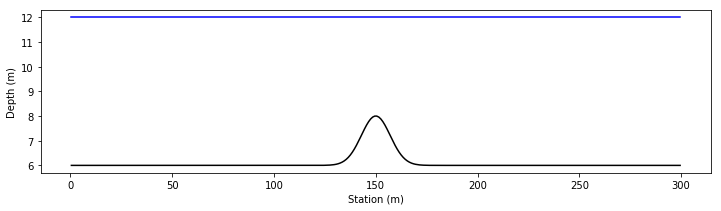

In [5]:
# Set up the constants
a=0.001
b=3.0
Q=10.0
nP=0.4
xcentre = 150.  # Centre of hum
h0 = 6.0        # Height of the dune
s= 12.0            # Datum
beta = 0.01
nx=300
x = pyclaw.Dimension(0.0,300.0,nx,name='x')
domain = pyclaw.Domain(x)
state = pyclaw.State(domain,1)
xc = state.grid.x.centers
dx = state.grid.delta[0]
print('Grid dx = {0}'.format(dx))
print('Grid nx = {0}'.format(len(xc)))

# Set up the bathymetry
z = np.zeros(nx)

# Eq 66
z = np.array([(h0 + 2.0*math.exp(-beta*(xp-xcentre)**2)) for xp in xc])
zc = z.copy()
z0 = zc.copy() 
fig = plt.figure(figsize=(12, 3))
surf = np.ones(nx) * s
plt.plot(xc, surf, 'b')
plt.plot(xc, zc,'k')

plt.xlabel('Station (m)')
plt.ylabel('Depth (m)')

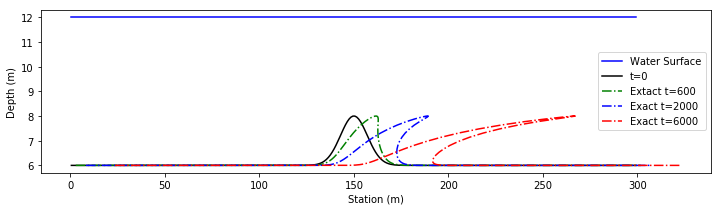

In [11]:
fig = plt.figure(figsize=(12, 3))
from schemes.weno import get_exact_solution
x_600, z_a600 = get_exact_solution(z0,xc, 0.4,s,a,b,10.,600.)
x_2000, z_a2000 = get_exact_solution(z0,xc, 0.4,s,a,b,10.,2000.)
x_6000, z_a6000 = get_exact_solution(z0,xc, 0.4,s,a,b,10.,6000.)
np.shape(x_600),np.shape(z_a600)

plt.plot(xc, surf, 'b', label='Water Surface')
plt.plot(xc,z0, label='t=0', color='k')

plt.plot(x_600, z_a600, 'g-.', label='Extact t=600',)
plt.plot(x_2000, z_a2000,'b-.', label='Exact t=2000')
plt.plot(x_6000, z_a6000,'r-.', label='Exact t=6000')

plt.xlabel('Station (m)')
plt.ylabel('Depth (m)')


plt.legend()

## TVD-WENO

In [16]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 6000 # Runtime in seconds
dt = 0.1 # Time step size (s)
extractionTime = 100.
nt = int(simTime/dt)  # Number of time st


import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

run_name = 'dune_5_q_{0}_h_{1}_TVD_WENO'.format(Q,'12')

model = shallow_models.ModifiedShallowHydroMorphologicalModel()
#--------------------------------
# Set up the geometry
#--------------------------------
x0 = xc.copy()
zc = z0.copy()
nx = len(xc)


model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(Q, 12.)
model.setup_chezy_hydro_model(0.00001, 0)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = sdmodels.EulerWenoModel()
morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = False, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)
#model.set_scale_factor(1)
#model.use_modifier()
#model.use_periodic_reattachment()

model.set_grass_parameters(a,b)

zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h

 Starting simulation....
Number of time steps: 1000.0 mins
Grid dx = 1.0
Grid nx = 300
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 1.6666666666666667 mins - uavg: 1.7172309824050038 - Elevation 11.995682491698885
Courant number: max 0.382544337213598, mean-0.03526109396133653
Time step: 3.3333333333333335 mins - uavg: 1.7206573325378924 - Elevation 11.995824385178754
Courant number: max 0.3643822198374653, mean-0.02054845996782577
Time step: 5.0 mins - uavg: 1.7224633236125062 - Elevation 11.99607178176721
Courant number: max 0.05669150529546364, mean-0.71065122137373
Time step: 6.666666666666667 mins - uavg: 1.7222135128147351 - Elevation 11.996367792147293
Courant number: max 0.7055933132885842, mean0.0034773341537333966
Time step: 8.333333333333334 mins - uavg: 1.7201693526677082 - Elevation 11.996381927146592
Courant number: max 0.13703921500832397, mean-0.0052597824012111

In [20]:
name = 'gaussian_tvdweno'
verts = model._verts
np.save('_output/{0}_verts.npy'.format(name),verts)
verts = np.load('_output/{0}_verts.npy'.format(name))

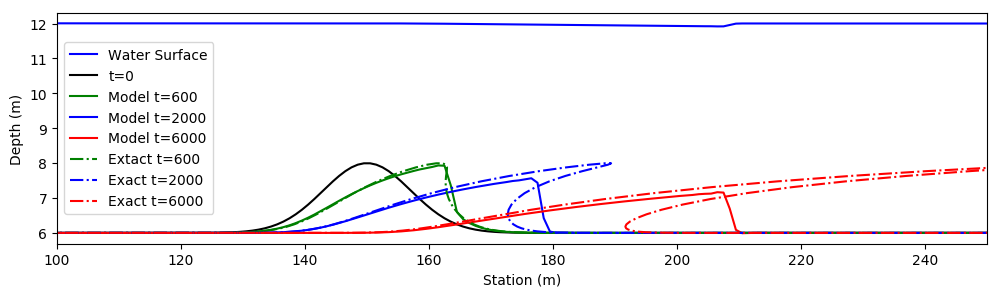

In [24]:
fig = plt.figure(figsize=(12, 3))
plt.plot(xc, surf, 'b', label='Water Surface')
plt.xlim(100,250)

z600 = verts[4,:,1]
z2000= verts[18,:,1]

plt.xlabel('Station (m)')
plt.ylabel('Depth (m)')

plt.plot(xc,z0, label='t=0', color='k')
plt.plot(xc, z600,label='Model t=600',color='g')
plt.plot(xc, z2000,label='Model t=2000',color='b')
plt.plot(xc, zc,label='Model t=6000',color='r')


plt.plot(x_600, z_a600, 'g-.', label='Extact t=600',)
plt.plot(x_2000, z_a2000,'b-.', label='Exact t=2000')
plt.plot(x_6000, z_a6000,'r-.', label='Exact t=6000')
plt.legend()

## Euler-WENO

In [25]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 6000 # Runtime in seconds
dt = 0.1 # Time step size (s)
extractionTime = 100.
nt = int(simTime/dt)  # Number of time st


import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

run_name = 'dune_5_q_{0}_h_{1}_TVD_WENO'.format(Q,'12')

model = shallow_models.ModifiedShallowHydroMorphologicalModel()
#--------------------------------
# Set up the geometry
#--------------------------------
x0 = xc.copy()
zc = z0.copy()
nx = len(xc)


model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(Q, 12.)
model.setup_chezy_hydro_model(0.00001, 0)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = sdmodels.EulerWenoModel()
morph_model = sdmodels.EulerWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = False, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)
#model.set_scale_factor(1)
#model.use_modifier()
#model.use_periodic_reattachment()

model.set_grass_parameters(a,b)

zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h

 Starting simulation....
Number of time steps: 1000.0 mins
Grid dx = 1.0
Grid nx = 300
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 1.6666666666666667 mins - uavg: 1.717231149672845 - Elevation 11.995682466601368
Courant number: max 0.5649016973027987, mean-0.0012559926830169792
Time step: 3.3333333333333335 mins - uavg: 1.7206568438487655 - Elevation 11.995824372404329
Courant number: max 2.5361725214180875, mean0.013495288945045205
Time step: 5.0 mins - uavg: 1.7224625194866743 - Elevation 11.99607178243134
Courant number: max 36.335367200551644, mean0.11971258461852471
Time step: 6.666666666666667 mins - uavg: 1.7222127118256965 - Elevation 11.996367805520944
Courant number: max 0.7393024883908638, mean0.003511012531361879
Time step: 8.333333333333334 mins - uavg: 1.720168858488587 - Elevation 11.996381942466838
Courant number: max 0.13354071183811875, mean-0.000299209102322

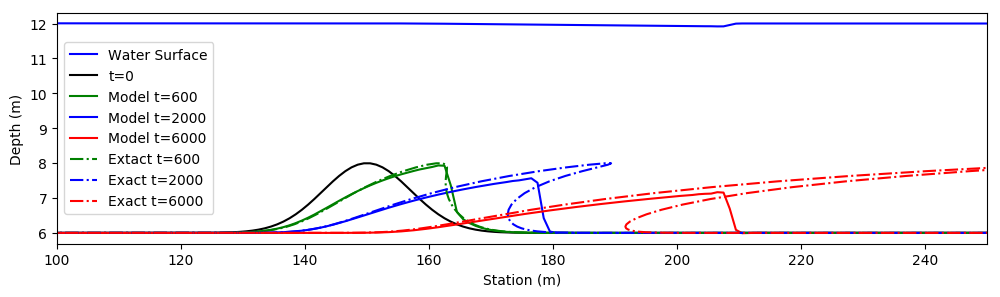

In [26]:
name = 'gaussian_eulerweno'
verts = model._verts
np.save('_output/{0}_verts.npy'.format(name),verts)
verts = np.load('_output/{0}_verts.npy'.format(name))

fig = plt.figure(figsize=(12, 3))
plt.plot(xc, surf, 'b', label='Water Surface')
plt.xlim(100,250)

z600 = verts[4,:,1]
z2000= verts[18,:,1]

plt.xlabel('Station (m)')
plt.ylabel('Depth (m)')

plt.plot(xc,z0, label='t=0', color='k')
plt.plot(xc, z600,label='Model t=600',color='g')
plt.plot(xc, z2000,label='Model t=2000',color='b')
plt.plot(xc, zc,label='Model t=6000',color='r')


plt.plot(x_600, z_a600, 'g-.', label='Extact t=600',)
plt.plot(x_2000, z_a2000,'b-.', label='Exact t=2000')
plt.plot(x_6000, z_a6000,'r-.', label='Exact t=6000')
plt.legend()

In [29]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 6000 # Runtime in seconds
dt = 0.1 # Time step size (s)
extractionTime = 100.
nt = int(simTime/dt)  # Number of time st


import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

run_name = 'dune_5_q_{0}_h_{1}_TVD_WENO'.format(Q,'12')

model = shallow_models.ModifiedShallowHydroMorphologicalModel()
#--------------------------------
# Set up the geometry
#--------------------------------
x0 = xc.copy()
zc = z0.copy()
nx = len(xc)


model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(Q, 12.)
model.setup_chezy_hydro_model(0.00001, 0)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = sdmodels.EulerWenoModel()
morph_model = sdmodels.MacCormackModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = False, 
                           useSmoother = True, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)
#model.set_scale_factor(1)
#model.use_modifier()
#model.use_periodic_reattachment()

model.set_grass_parameters(a,b)

zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h

 Starting simulation....
Number of time steps: 1000.0 mins
Grid dx = 1.0
Grid nx = 300
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 1.6666666666666667 mins - uavg: 1.7129914423594066 - Elevation 11.995861253791094
Courant number: max 0.2568677757317653, mean-0.03199955452881431
Time step: 3.3333333333333335 mins - uavg: 1.7123573934799765 - Elevation 11.996069622968877
Courant number: max 0.1399472073329737, mean-0.006575026788724186
Time step: 5.0 mins - uavg: 1.7118537046707047 - Elevation 11.996231470851368
Courant number: max 0.18629908328549818, mean-0.0004246119027359285
Time step: 6.666666666666667 mins - uavg: 1.711433286494474 - Elevation 11.996364958363454
Courant number: max 0.25875259607589174, mean0.0011731637381907519
Time step: 8.333333333333334 mins - uavg: 1.7110712364846492 - Elevation 11.996479063290451
Courant number: max 0.19967873794813762, mean0.000679388

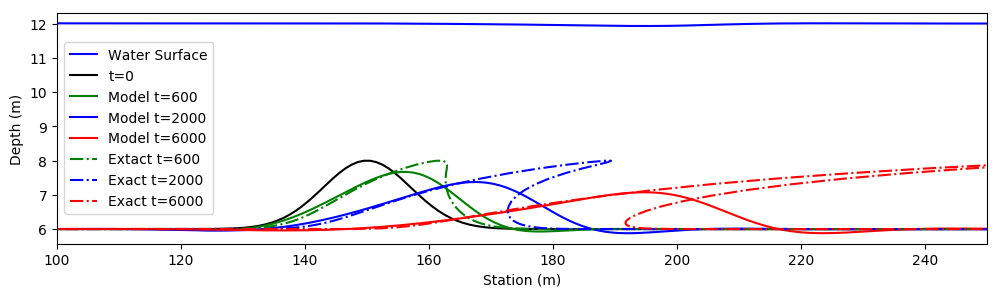

In [30]:
name = 'gaussian_maccormack'
verts = model._verts
np.save('_output/{0}_verts.npy'.format(name),verts)
verts = np.load('_output/{0}_verts.npy'.format(name))

fig = plt.figure(figsize=(12, 3))
plt.plot(xc, surf, 'b', label='Water Surface')
plt.xlim(100,250)

z600 = verts[4,:,1]
z2000= verts[18,:,1]

plt.xlabel('Station (m)')
plt.ylabel('Depth (m)')

plt.plot(xc,z0, label='t=0', color='k')
plt.plot(xc, z600,label='Model t=600',color='g')
plt.plot(xc, z2000,label='Model t=2000',color='b')
plt.plot(xc, zc,label='Model t=6000',color='r')


plt.plot(x_600, z_a600, 'g-.', label='Extact t=600',)
plt.plot(x_2000, z_a2000,'b-.', label='Exact t=2000')
plt.plot(x_6000, z_a6000,'r-.', label='Exact t=6000')
plt.legend()